In [31]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import os

import cv2

from tqdm import tqdm


In [32]:
image_size = (180, 180)
batch_size = 32

train_ds = tf.keras.utils.image_dataset_from_directory(
    "/kaggle/input/pokemon-generation-one-22k/PokemonData",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
print(train_ds)

Found 22623 files belonging to 151 classes.
Using 18099 files for training.
<BatchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [33]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    "/kaggle/input/pokemon-generation-one-22k/PokemonData",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
print(val_ds)

Found 22623 files belonging to 151 classes.
Using 4524 files for validation.
<BatchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


2023-02-19 22:51:43.694587: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


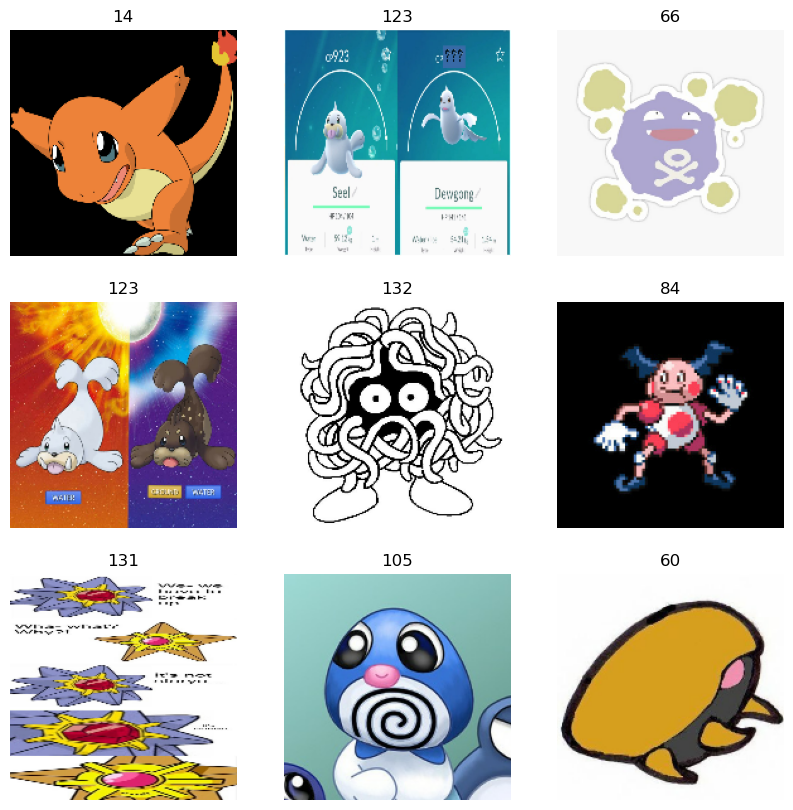

In [34]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [35]:


IMG_SIZE = 50
def load_images_from_folder(folder):
    images = []
    for folders in tqdm(os.listdir(folder)):
      for filename in os.listdir(os.path.join(folder,folders)):
#           print(folders,filename)
          if(filename==".DS_Store"):
            continue
          if(filename.split(".")[1]=="jpg"):
            img = cv2.imread(os.path.join(folder,os.path.join(folders,filename)))
            img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
            img = img/255
            if img is not None:
              images.append([np.array(img),folders])
    return images

In [36]:
train1 = load_images_from_folder("/kaggle/input/pokemon-generation-one-22k/PokemonData")

100%|██████████| 151/151 [03:32<00:00,  1.41s/it]


In [37]:

train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

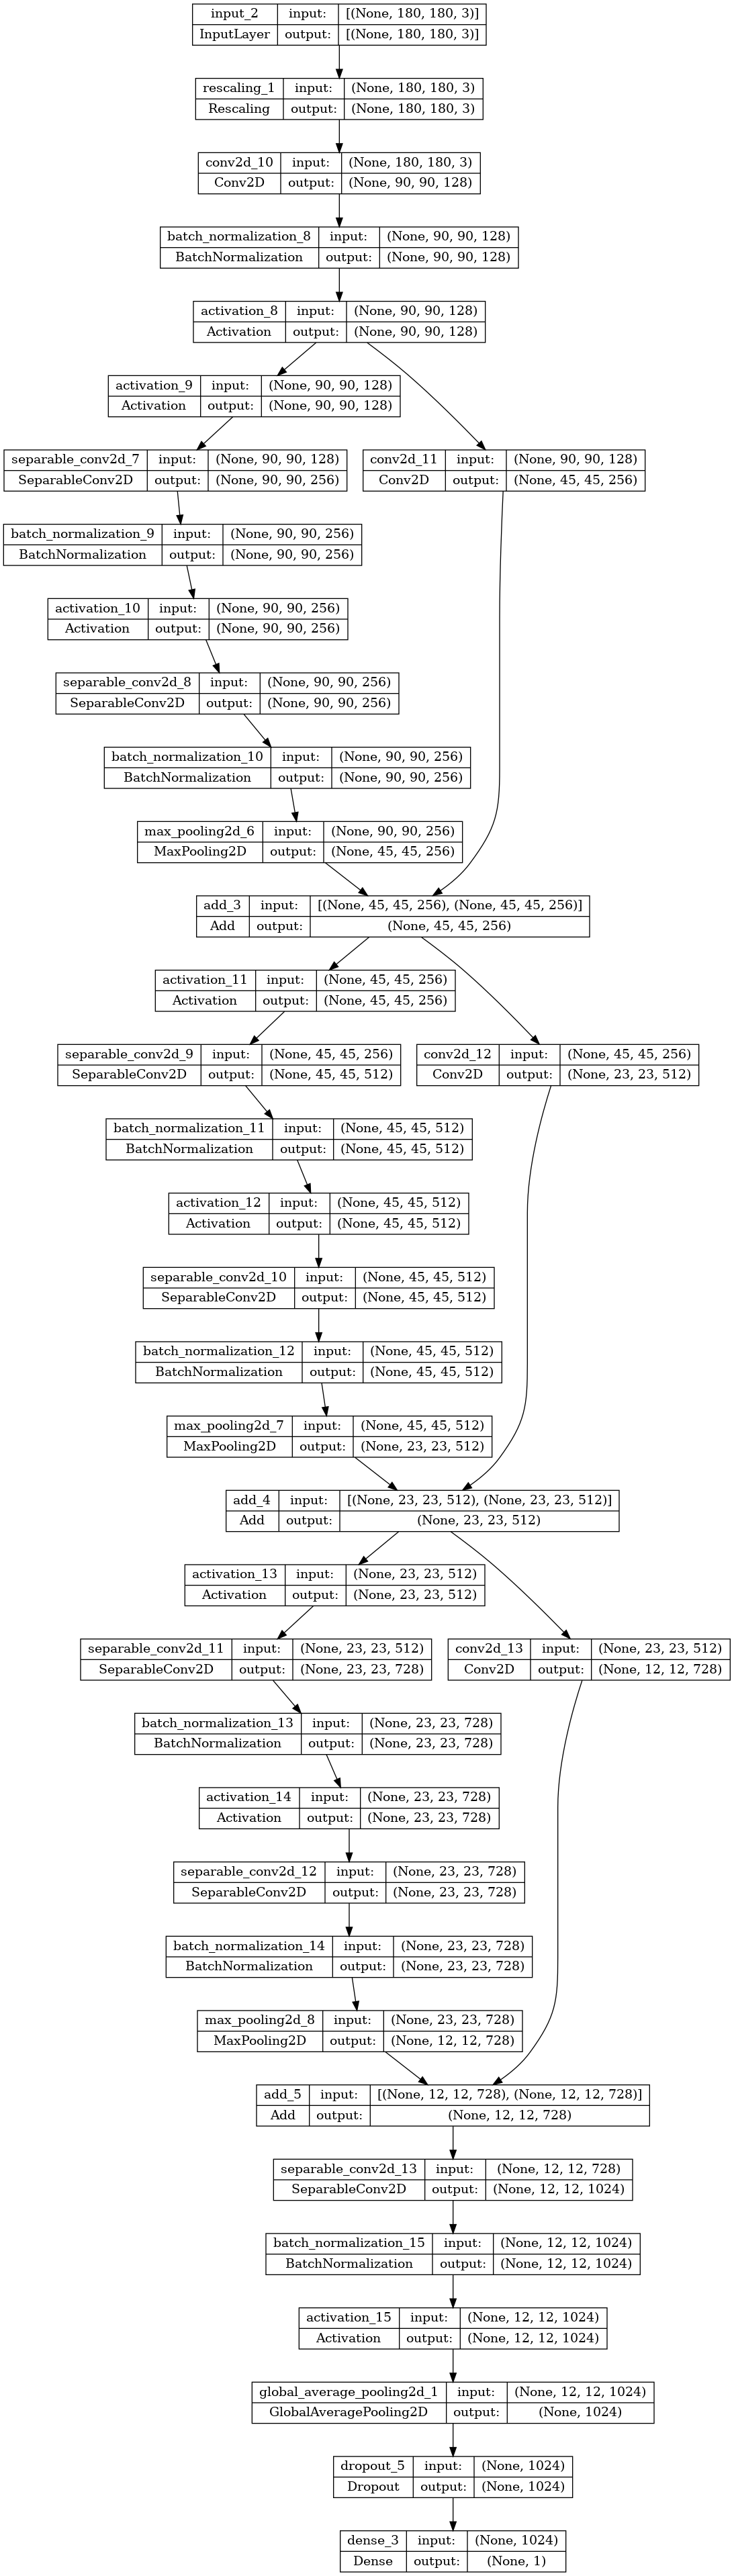

In [38]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

In [39]:
len(train1)
x = []
y = []
for i in train1:
    x.append(i[0])
    y.append(i[1])

In [40]:
x = np.array(x)


In [41]:
type(y)

list

In [42]:
from sklearn.preprocessing import LabelBinarizer
encoder = LabelBinarizer()
y_train1 = encoder.fit_transform(y)
len(encoder.classes_)

151

In [43]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
     

nClasses = 149

#constructing the model
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(50,50,3)))
model.add(Conv2D(32, (3, 3), activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
 
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
 
model.add(Conv2D(96, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(96, (3, 3), activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(nClasses, activation='softmax'))

In [44]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
print(model.summary())
     

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 50, 50, 32)        896       
                                                                 
 conv2d_15 (Conv2D)          (None, 50, 50, 32)        9248      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 25, 25, 32)       0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 25, 25, 32)        0         
                                                                 
 conv2d_16 (Conv2D)          (None, 25, 25, 64)        18496     
                                                                 
 conv2d_17 (Conv2D)          (None, 25, 25, 64)        36928     
                                                      

In [47]:
model.fit(x,y_train1,epochs =100,batch_size = 50)


Epoch 1/100


ValueError: in user code:

    File "/opt/conda/lib/python3.7/site-packages/keras/engine/training.py", line 1051, in train_function  *
        return step_function(self, iterator)
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/training.py", line 1040, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/training.py", line 1030, in run_step  **
        outputs = model.train_step(data)
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/training.py", line 890, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/training.py", line 949, in compute_loss
        y, y_pred, sample_weight, regularization_losses=self.losses)
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/compile_utils.py", line 201, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/opt/conda/lib/python3.7/site-packages/keras/losses.py", line 139, in __call__
        losses = call_fn(y_true, y_pred)
    File "/opt/conda/lib/python3.7/site-packages/keras/losses.py", line 243, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/opt/conda/lib/python3.7/site-packages/keras/losses.py", line 1788, in categorical_crossentropy
        y_true, y_pred, from_logits=from_logits, axis=axis)
    File "/opt/conda/lib/python3.7/site-packages/keras/backend.py", line 5119, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (None, 151) and (None, 149) are incompatible
